In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.utils import shuffle
from PIL import ImageFont
import datetime

In [2]:
%matplotlib inline
mpl.style.use('seaborn')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
!rm -rf ./logs/
!rm -rf /home2/kalp_shah/tmp/backup

In [6]:
import tensorflow as tf
%load_ext tensorboard

In [7]:
files = ['ttbar','wmp','wpwm','zwpm','n2n2']

cs_lo_k = {
            'ttbar':988.57,
            'wmp'  :1.95*1e5,
            'wpwm' :124.31,
            'zwpm' :51.82,
            'n2n2' :1
          }

br_ratio = {
            'ttbar':0.67*(1-0.67)*2,
            'wmp'  :(1-0.67),
            'wpwm' :(1-0.67)*0.67*2,
            'zwpm' :0.7*(1-0.67),
            'n2n2' :1
          }

cs_nmg = {
         'ttbar':393.30,
         'wmp'  :7.865*1e4,
         'wpwm' :74.96,
         'zwpm' :14.28,
         'n2n2' :1
         }

cs_mg = {'ttbar':5.883,
          'wmp':111.5,
          'wpwm':0.944,
          'zwpm':0.2381,
          'n2n2':3.99*1e-4
        }

cs_pb = []
for f in files:
    cs_pb.append((cs_lo_k[f]*br_ratio[f]*cs_mg[f])/cs_nmg[f])

cs = [i*1e3 for i in cs_pb]
#k_f = [1.954,1.356,1.92,2.09,1.0]

cs_corr = {files[i] : cs[i] for i in range(len(files))}

In [8]:
no_of_files = {'ttbar':0,
          'wmp':0,
          'wpwm':0,
          'zwpm':0,
          'n2n2':0
        }

In [9]:
df = []
for f in range(len(files)):
    con_df = []
    
    for i in range(1,53):
        try:
            con_df.append(pd.read_csv('~/neutrino/datasets/csvdata/' + files[f] + str(i) + '.csv'))
            no_of_files[files[f]] += 1
        except:
            pass
            #print("Not Here : ",files[f],i)
    
    df.append(pd.concat(con_df,ignore_index=True))
    df[-1]['type'] = f
    
    if files[f] == "n2n2":
        df[-1]['tag'] = 1
    else:
        df[-1]['tag'] = 0

In [10]:
tot_num = 0
for i in no_of_files.keys():
    tot_num += no_of_files[i]*1e5
    print("For the process ",i," the number of events : ",no_of_files[i]*1e5)
print('Number of Datapoints Considered : ',tot_num)

For the process  ttbar  the number of events :  4100000.0
For the process  wmp  the number of events :  4000000.0
For the process  wpwm  the number of events :  2800000.0
For the process  zwpm  the number of events :  4400000.0
For the process  n2n2  the number of events :  3900000.0
Number of Datapoints Considered :  19200000.0


In [11]:
df[-1].head()

,ptl,etal,energyl,ptj,etaj,energyj,massj,mjj,rjj,rjl,met,n21_1,n21_2,n32_1,n32_2,infl,drfl,type,tag
0,576.562,0.232894,592.269,459.681,0.248122,475.279,36.1316,379.243,1.14509,2.253050,889.067,0.190804,0.258472,0.517955,0.670891,769.506,1.86471,4,1
1,823.599,-0.418800,896.887,339.247,-0.696095,431.789,77.3122,1052.580,2.67178,2.072780,1930.330,0.197178,0.222316,0.468612,0.544453,1113.560,1.81712,4,1
2,354.758,-1.721930,1024.200,883.807,-0.817714,1200.200,98.7750,1764.850,2.82048,0.922735,3256.570,0.328865,0.361102,0.409280,0.760725,1015.050,2.09248,4,1
3,858.275,0.386685,923.245,1258.810,0.184948,1285.290,112.0150,1546.480,1.12283,2.551460,388.116,0.216487,0.234383,0.308864,0.722296,510.332,2.04593,4,1
4,590.040,-0.006999,590.055,811.602,0.445120,897.952,90.8938,818.864,1.16291,1.495500,1133.330,0.172456,0.329166,0.461283,0.696238,351.882,3.21196,4,1


In [12]:
dtset = pd.concat(df,ignore_index=True)
dtset = shuffle(dtset)
dtset['met'] = np.fabs(dtset['met'])

In [13]:
## Analysis Level Cuts
dtset = dtset[dtset['ptl'] >= 120.0][dtset['ptj'] >= 120.0][dtset['etaj'] <= 2.0][dtset['etaj'] >= -2.0]

In [14]:
dtset.head()

,ptl,etal,energyl,ptj,etaj,energyj,massj,mjj,rjj,rjl,met,n21_1,n21_2,n32_1,n32_2,infl,drfl,type,tag
10203254,1173.670,0.386810,1262.580,775.481,-0.115199,787.410,103.0940,639.424,2.158690,2.76115,500.296,0.110379,0.125530,0.473919,0.759219,998.904,1.848560,4,1
11883409,362.187,0.683594,450.159,1307.980,-0.936864,1928.470,111.6770,1513.680,0.365434,3.29605,1475.510,0.147008,0.422370,0.092557,0.312592,136.041,0.756092,4,1
12466758,592.609,-0.988347,906.390,657.588,0.449680,736.198,126.7600,1186.850,3.002440,2.51067,810.704,0.000000,0.167276,0.293694,0.688772,632.996,2.950870,4,1
10952340,301.481,-0.006120,301.487,691.000,-1.198450,1252.270,82.6701,1497.270,2.377630,2.72930,733.313,0.211088,0.672162,0.579263,0.793581,793.335,1.045860,4,1
10725742,391.883,-0.877508,552.696,764.035,1.043140,1220.730,68.4303,1481.820,2.768630,2.68507,844.666,0.264665,0.313923,0.344353,0.713931,290.202,3.097090,4,1


In [ ]:
train_len = int(0.8*len(dtset))
x_train = dtset.T[:-2].T[:train_len]
y_train = dtset['tag'][:train_len]

x_test = dtset.T[:-2].T[train_len:]
y_test = dtset['tag'][train_len:]

print('Shapes : ',x_train.shape,y_train.shape,x_test.shape,y_test.shape)

Shapes :  (9034704, 17) (9034704,) (2258676, 17) (2258676,)


In [ ]:
# Callbacks
backup_callback = tf.keras.callbacks.experimental.BackupAndRestore(backup_dir="/home2/kalp_shah/tmp/backup")

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [23]:
model = Sequential()
input_shape = x_train.shape

from keras.layers.normalization.batch_normalization import BatchNormalization
model.add(Dense(10,activation = 'relu',input_dim = input_shape[1]))
model.add(BatchNormalization())
model.add(Dense(20,activation = 'relu',input_dim = 10))
model.add(BatchNormalization())
model.add(Dense(40,activation = 'relu',input_dim = 20))
model.add(BatchNormalization())
model.add(Dense(20,activation = 'relu',input_dim = 40))
model.add(BatchNormalization())
model.add(Dense(12,activation = 'relu',input_dim = 20))
model.add(BatchNormalization())
model.add(Dense(8,activation = 'relu',input_dim = 12))
model.add(BatchNormalization())
model.add(Dense(1,activation = 'sigmoid',input_dim = 8))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

2022-04-05 11:27:56.639889: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-05 11:27:56.639950: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: gnode51
2022-04-05 11:27:56.639959: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: gnode51
2022-04-05 11:27:56.640101: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 440.118.2
2022-04-05 11:27:56.640130: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 440.118.2
2022-04-05 11:27:56.640137: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 440.118.2
2022-04-05 11:27:56.640643: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in

In [18]:
try:
    model.fit(x_train,y_train,epochs=100,batch_size=1024,validation_split=0.4,
              class_weight={0:.995,1:0.005},callbacks=[backup_callback,tensorboard_callback])

except:
    pass

Epoch 1/100
5294/5294 [==============================] - 32s 6ms/step - loss: 0.0143 - accuracy: 0.7965 - val_loss: 0.6663 - val_accuracy: 0.7811
Epoch 2/100
5294/5294 [==============================] - 30s 6ms/step - loss: 0.0044 - accuracy: 0.7814 - val_loss: 0.5528 - val_accuracy: 0.8036
Epoch 3/100
5294/5294 [==============================] - 30s 6ms/step - loss: 0.0041 - accuracy: 0.7929 - val_loss: 0.5821 - val_accuracy: 0.7934
Epoch 4/100
5294/5294 [==============================] - 30s 6ms/step - loss: 0.0039 - accuracy: 0.8002 - val_loss: 0.6466 - val_accuracy: 0.7884
Epoch 5/100
5294/5294 [==============================] - 30s 6ms/step - loss: 0.0039 - accuracy: 0.8005 - val_loss: 0.5952 - val_accuracy: 0.8028
Epoch 6/100
5294/5294 [==============================] - 30s 6ms/step - loss: 0.0039 - accuracy: 0.8027 - val_loss: 0.5253 - val_accuracy: 0.8096
Epoch 7/100
5294/5294 [==============================] - 30s 6ms/step - loss: 0.0038 - accuracy: 0.8054 - val_loss: 0.5537 -

In [19]:
%tensorboard --logdir logs/fit --port 8008

In [20]:
tot_pred = model.evaluate(dtset.T[:-2].T,dtset['tag'],batch_size=1024)

11029/11029 [==============================] - 16s 1ms/step - loss: 0.5590 - accuracy: 0.7990


In [21]:
tot_pred

[0.5589563250541687, 0.7990209460258484]

In [37]:
pred_set = dtset.copy()
pred_set['pred'] = tot_pred

In [38]:
cor_pred = len(pred_set[train_len:][pred_set['pred'] >= 0.5][pred_set['tag'] == 1]) + len(pred_set[train_len:][pred_set['pred'] < 0.5][pred_set['tag'] == 0])
print('The accuracy of the test set is : ',cor_pred/(len(pred_set[train_len:])))

The accuracy of the test set is :  0.834579473433965


In [39]:
print('Correctly identified signal (True Positive)     : ',len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 1]))
print('Falsely identified signal (Flase Positive)      : ',len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 0]))
print('Correctly identified background (True Negative) : ',len(pred_set[pred_set['pred'] < 0.5][pred_set['tag'] == 0]))
print('Falsely identified background (False Negative)  : ',len(pred_set[pred_set['pred'] < 0.5][pred_set['tag'] == 1]))

Correctly identified signal (True Positive)     :  338105
Falsely identified signal (Flase Positive)      :  1174
Correctly identified background (True Negative) :  2057912
Falsely identified background (False Negative)  :  473672


In [40]:
print('The amount of signal left is     :', len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 1])/len(df[-1]))
print('The amount of background left is :', len(pred_set[pred_set['pred'] >= 0.5][pred_set['tag'] == 0])/np.sum([len(i) for i in df[:-1]]))

The amount of signal left is     : 0.39959698149778694
The amount of background left is : 0.0004783490032698047


In [41]:
print('Thus, the rate of correct signal prediction is : ',len(pred_set[pred_set['pred'] >= 0.5][dtset['tag'] == 1])/(len(pred_set[pred_set['pred'] >= 0.5])))

Thus, the rate of correct signal prediction is :  0.9965397209965839


In [42]:
L = 3000

In [45]:
ns = cs_corr['n2n2']*(len(pred_set[pred_set['pred'] >= 0.7][pred_set['tag'] == 1])/(1e6))*L
print('n2n2',cs_corr['n2n2'],(len(pred_set[pred_set['pred'] >= 0.7][pred_set['tag'] == 1])))
nb = 0

for i in range(len(files)-1):
    nb += cs_corr[files[i]]*(len(pred_set[pred_set['pred'] >= 0.7][pred_set['tag'] == 0][pred_set['type'] == i])/((1e6)))*L
    print(files[i],len(pred_set[pred_set['pred'] >= 0.7][pred_set['tag'] == 0][pred_set['type'] == i]),cs_corr[files[i]])

n2n2 0.399 224090
ttbar 5 6538.845366086956
wmp 30 91227.27272727272
wpwm 163 692.2567850586979
zwpm 185 199.5908264705882


In [46]:
print('The number of signal is :', ns)
print('The number of background is :', nb)
print('The significance is :',ns/np.sqrt(nb))

The number of signal is : 268.23573000000005
The number of background is : 8757.823702530732
The significance is : 2.86627943545068


In [24]:
model.save('/home2/kalp_shah/datasets/models/s4')

2022-03-28 12:42:52.648281: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home2/kalp_shah/datasets/models/s4/assets


In [28]:
import tensorflow_probability as tfp
cor = tfp.stats.correlation(dtset.values[:-2,:-2])

In [29]:
for i in range(len(cor)):
    for j in range(len(cor[i])):
        if cor[i,j] > 0.8 and i!=j:
            print(dtset.keys()[i],dtset.keys()[j],cor[i,j].numpy())

ptj energyj 0.8332972254692859
energyj ptj 0.8332972254692859


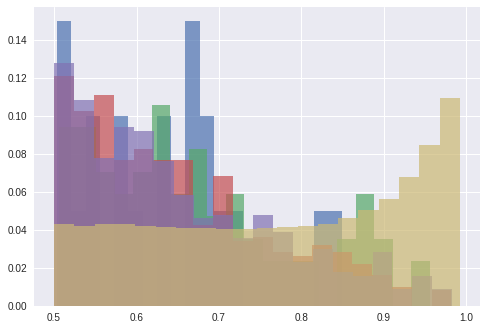

In [65]:
for i in range(len(files)):
    data = pred_set[pred_set["type"] == i][pred_set["pred"]>=0.5]["pred"].values
    plt.hist(data,alpha=0.7,bins=20,weights=np.ones_like(data)/len(data))
plt.show()

In [53]:
pred_set[pred_set["type"] == 0]["pred"].values

array([2.5260133e-06, 9.0794361e-05, 9.8490336e-06, ..., 9.6628992e-07,
       2.2237360e-02, 1.9050436e-05], dtype=float32)